# Building a prediction model on house prices
Data Analysis 3 - Assignment 1  
Submitted by: Zariza Chowdhury (ID: 2500086)    
Deadline: 2 February 2026

## Business Case
My business case is to operate a chain of Airbnbs.      
The task is to build a pricing model.

## Part I. Modelling

### Step 0: Setup
Import the necessary libraries

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn: models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Scikit-learn: evaluation
from sklearn.metrics import mean_squared_error

# Interpretable ML
import shap

import os
import time

### Step 1: Data Selection, Wrangling and Feature Engineering

##### A. Dataset Selection:
- **Source**: Inside Airbnb - *https://insideairbnb.com/get-the-data/*
- **Dataset**: *listings.csv* (loaded directly from GitHub Repo)
- **City, Country**: Tokyo, Japan
- **Time Period**: Q4 2024
- **Reproducibility**: Data is uploaded and stored in a public GitHub repo and loaded directly via a raw URL

Load the Dataset

In [3]:
# Load dataset
url = "https://raw.githubusercontent.com/zarizachow/Data-Analysis-3/refs/heads/main/Assignment-1/Data/Raw/Tokyo_listings/Tokyo_2024-30-Dec/listings.csv"
df = pd.read_csv(url)

# Basic inspection
print("Shape (rows, columns):", df.shape)

print("\nColumn names:")
print(df.columns)

print("\nData types and missing values:")
df.info()

print("\nFirst 5 rows:")
df.head()

Shape (rows, columns): (21058, 75)

Column names:
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nig

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20241230011552,2024-12-30,city scrape,Oshiage Holiday Apartment,NaN,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.84,4.56,4.80,M130003350,f,1,1,0,0,1.13
1,776070,https://www.airbnb.com/rooms/776070,20241230011552,2024-12-30,city scrape,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.84,4.92,M130000243,f,1,0,1,0,1.79
2,905944,https://www.airbnb.com/rooms/905944,20241230011552,2024-12-30,city scrape,4F Spacious Apartment in Shinjuku / Shibuya Tokyo,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.91,4.78,4.78,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,8,8,0,0,1.69
3,1016831,https://www.airbnb.com/rooms/1016831,20241230011552,2024-12-30,city scrape,5 mins Shibuya Cat modern sunny Shimokita,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.92,4.90,M130001107,f,1,0,1,0,1.90
4,1196177,https://www.airbnb.com/rooms/1196177,20241230011552,2024-12-30,city scrape,Homestay at Host's House - Senju-Ohashi Station,Our accommodation offers: <br /><br />1. **Gr...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.92,4.74,4.82,M130007760,f,1,0,1,0,0.97


##### B. Data Wrangling and Feature Engineering

**Handle Missing Values**

- Identify missing values across numeric and categorical variables - to ensure that all models can be estimated without errors
- Impute numeric variables using simple summary statistics - this is a simple and robust method so the clean dataset is not sensitive to outliers
- Treat missing categorical values as a separate category where needed - to preserve information and avoid dropping observations

In [4]:
# Handle missing values

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# Impute numeric variables with median
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical variables with explicit category
for col in categorical_cols:
    df[col] = df[col].fillna("missing")

# Sanity check
df.isnull().sum().sort_values(ascending=False).head()

neighbourhood_group_cleansed    21058
calendar_updated                21058
minimum_nights_avg_ntm              0
availability_365                    0
availability_90                     0
dtype: int64

**Clean and Standardize Numeric Variables**

- Inspect numeric variables for unrealistic or extreme values – to identify potential data quality issues
- Apply simple cleaning rules and transformations where needed – to ensure the variables are consistent
- Standardize the format of the numeric variables – to support estimation across different predictive models

In [5]:
# Clean and standardize numeric variables

# Fix price variable (it may contain strings or missing)
df["price"] = df["price"].replace("missing", np.nan)

df["price"] = (
    df["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Impute missing price values with median
df["price"] = df["price"].fillna(df["price"].median())

# Update numeric columns after cleaning price
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Inspect summary statistics
df[numeric_cols].describe().T

# Cap extreme values (simple winsorization)
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

# Sanity check after cleaning
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
id,21058.0,7.505109e+17,5.214894e+17,8.998859e+06,4.632186e+07,9.859087e+17,1.188786e+18,1.313531e+18
scrape_id,21058.0,2.024123e+13,1.035962e+01,2.024123e+13,2.024123e+13,2.024123e+13,2.024123e+13,2.024123e+13
host_id,21058.0,3.326076e+08,1.985555e+08,6.648140e+06,1.542259e+08,3.303169e+08,5.272325e+08,6.619167e+08
host_listings_count,21058.0,2.429951e+01,3.015113e+01,1.000000e+00,4.000000e+00,1.100000e+01,3.200000e+01,1.410000e+02
host_total_listings_count,21058.0,3.146866e+01,4.109053e+01,1.000000e+00,6.000000e+00,1.500000e+01,3.900000e+01,2.149100e+02
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,21058.0,3.569799e+01,4.157748e-02,3.555644e+01,3.568777e+01,3.570394e+01,3.572249e+01,3.577726e+01
longitude,21058.0,1.397380e+02,6.482399e-02,1.394746e+02,1.396993e+02,1.397276e+02,1.397923e+02,1.398767e+02
accommodates,21058.0,4.436984e+00,2.955584e+00,1.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,1.600000e+01
bathrooms,21058.0,1.130331e+00,3.829521e-01,5.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00


In [6]:
# Ensure target variable (price) is numeric (avoid errors in models)

df["price"] = (
    df["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Drop rows where price is missing
df = df.dropna(subset=["price"])

# Sanity check
df["price"].dtype, df["price"].isna().sum(), df.shape

(dtype('float64'), np.int64(0), (21058, 75))

In [8]:
# Drop unusable variables (except id)

# Columns with all missing values
all_missing_cols = [
    "neighbourhood_group_cleansed",
    "calendar_updated"
]

# System-generated id columns
id_cols = [
    "scrape_id"
]

cols_to_drop = [col for col in all_missing_cols + id_cols if col in df.columns]
df = df.drop(columns=cols_to_drop)

# Sanity check
print("Dropped columns:", cols_to_drop)
print("New shape:", df.shape)

Dropped columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'scrape_id']
New shape: (21058, 72)


**Variable Selection for Modelling**

- Exclude id, URLs, dates, and free-text fields that are not useful for prediction  
- Keep structured listing, host, location, and amenity variables  
- Use the same variables across all datasets for out-of-sample comparison

**Extract Amenities**

- Parse the amenities text field into structured variables – to make the data usable  
- Create binary indicators for selected amenities – to capture key listing features  
- Use amenity features as additional inputs in the models

In [7]:
# Extract amenities

# Convert amenities column to string
df["amenities"] = df["amenities"].astype(str)

# List of selected amenities to extract
amenities_list = [
    "Wifi",
    "Kitchen",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer",
    "Elevator",
    "TV"
]

# Create binary indicators for each amenity
for amenity in amenities_list:
    df[f"amenity_{amenity.lower().replace(' ', '_')}"] = (
        df["amenities"].str.contains(amenity, case=False, regex=False).astype(int)
    )

# Drop original amenities text field
df = df.drop(columns=["amenities"])

# Sanity check
df.filter(like="amenity_").head()

,amenity_wifi,amenity_kitchen,amenity_air_conditioning,amenity_heating,amenity_washer,amenity_dryer,amenity_elevator,amenity_tv
0,1,1,1,1,1,1,0,1
1,1,0,1,1,0,1,0,1
2,1,1,0,1,0,1,0,1
3,1,1,0,1,1,1,0,1
4,1,0,0,1,1,1,0,1


**Save Cleaned Dataset**

In [8]:
# Save cleaned Tokyo Q4 2024 dataset

output_path = "Data/Cleaned/Tokyo_listings/tokyo_listings_q4_2024_clean.csv"

# Overwrite file if it already exists
df.to_csv(output_path, index=False)

print("Cleaned dataset saved (overwrite if existed):")
print(output_path)

Cleaned dataset saved (overwrite if existed):
Data/Cleaned/Tokyo_listings/tokyo_listings_q4_2024_clean.csv


**Encode Categorical Variables**

- Select relevant categorical variables  
- Convert categorical variables into numeric form  
- Use the same encoding across all datasets

In [9]:
# Encode categorical variables

# Select categorical variables
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Exclude variables not used for modelling
categorical_cols = [
    col for col in categorical_cols
    if col not in ["id"]  # keep id as primary key, but not as a feature
]

# Sanity check
categorical_cols

['listing_url',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'license',
 'instant_bookable']

### Step 2: Build Predictive Models

##### A. OLS Model

- Define target variable (`price`) and feature matrix (`X`)  
- Split data into training and test sets  
- Fit an OLS baseline model and generate predictions

In [10]:
# OLS model (with imputation in pipeline)

from sklearn.impute import SimpleImputer
import time

start_time_ols = time.time()

# Define target and features
y = df["price"]
X = df.drop(columns=["price", "id"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# OLS pipeline
ols_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ]
)

# Fit model
ols_model.fit(X_train, y_train)

# Predictions
y_pred_ols = ols_model.predict(X_test)

# Evaluation (RMSE)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
runtime_ols = time.time() - start_time_ols

print("OLS Model RMSE:", rmse_ols)
print("OLS Model Runtime (s):", round(runtime_ols, 2))


OLS Model RMSE: 12740.670851944502
OLS Model Runtime (s): 4.8


##### B. LASSO Model

- Use the same target variable and feature set as in the OLS model  
- Fit a LASSO model to allow coefficient shrinkage  
- Predict prices on the test set and evaluate model performance

In [11]:
# Restrict categorical variables before LASSO to avoid huge dummy matrix

# Define categorical variables to keep (class-style)
categorical_keep = [
    "room_type",
    "property_type",
    "neighbourhood_cleansed",
    "host_is_superhost",
    "instant_bookable"
]

# Keep only those that exist in the dataset
categorical_keep = [c for c in categorical_keep if c in df.columns]

# Define target and features
y = df["price"]
X = df.drop(columns=["price", "id"])

# Drop all other object/string columns
object_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
drop_cols = [c for c in object_cols if c not in categorical_keep]

X = X.drop(columns=drop_cols)

# Sanity check
print("Categorical variables kept:", categorical_keep)
print("Number of object/string columns dropped:", len(drop_cols))
print("Final feature shape:", X.shape)

Categorical variables kept: ['room_type', 'property_type', 'neighbourhood_cleansed', 'host_is_superhost', 'instant_bookable']
Number of object/string columns dropped: 28
Final feature shape: (21058, 52)


In [12]:
# LASSO model

start_time_lasso = time.time()

# Train-test split (using the restricted X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Preprocessing
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_lasso = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# LASSO pipeline
lasso_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_lasso),
        ("model", Lasso(alpha=1.0, max_iter=3000))
    ]
)

# Fit model
lasso_model.fit(X_train, y_train)

# Predictions
y_pred_lasso = lasso_model.predict(X_test)

# Evaluation (RMSE)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
runtime_lasso = time.time() - start_time_lasso

print("LASSO Model RMSE:", rmse_lasso)
print("LASSO Model Runtime (s):", round(runtime_lasso, 2))

LASSO Model RMSE: 15064.244563773585
LASSO Model Runtime (s): 1.6


##### C. Random Forest Model

- Use the same target variable and working feature set (`X`, `y`)  
- Fit a Random Forest model and generate predictions  
- Evaluate performance on the test set (RMSE)

In [13]:
# Random Forest model

start_time_rf = time.time()

# Train-test split (using the same working X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Preprocessing
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Random Forest pipeline (final, faster spec)
rf_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_rf),
        ("model", RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_leaf=5,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

# Fit model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation (RMSE)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
runtime_rf = time.time() - start_time_rf

print("Random Forest Model RMSE:", rmse_rf)
print("Random Forest Model Runtime (s):", round(runtime_rf, 2))

Random Forest Model RMSE: 13854.81045176692
Random Forest Model Runtime (s): 1.11


##### D. Boosting Model (Gradient Boosting)

- **Chosen model**: Gradient Boosting
- **Reason for choosing this model**: This is common boosting method used in class that performs well on tabular data and allows feature importance analysis

In [14]:
# Gradient Boosting model

start_time_gb = time.time()

# Train-test split (using the same working X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Preprocessing (same as Random Forest)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Gradient Boosting pipeline
gb_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_gb),
        ("model", GradientBoostingRegressor(random_state=42))
    ]
)

# Fit model
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluation (RMSE)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
runtime_gb = time.time() - start_time_gb

print("Gradient Boosting Model RMSE:", rmse_gb)
print("Gradient Boosting Model Runtime (s):", round(runtime_gb, 2))

Gradient Boosting Model RMSE: 14192.993833220631
Gradient Boosting Model Runtime (s): 10.65


##### E. Decision Tree

- **Chosen model**: Decision Tree (CART)  
- **Reason for choosing the model**: This is a simple tree-based model which provides a clear baseline to compare with ensemble methods

In [15]:
# Decision Tree model (CART)

start_time_dt = time.time()

# Train-test split (using the same working X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Preprocessing (same as RF and Boosting)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor_dt = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Decision Tree pipeline
dt_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_dt),
        ("model", DecisionTreeRegressor(random_state=42))
    ]
)

# Fit model
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluation (RMSE)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
runtime_dt = time.time() - start_time_dt

print("Decision Tree Model RMSE:", rmse_dt)
print("Decision Tree Model Runtime (s):", round(runtime_dt, 2))

Decision Tree Model RMSE: 17874.824077705467
Decision Tree Model Runtime (s): 1.53


### Step 3: Compare the Models in Terms of Fit and Time

##### A. Horserace Table

The horserace table compares the 5 models in terms of predictive accuracy and computation time.

- **RMSE** is used to measure out-of-sample prediction error. Lower RMSE values indicate better predictive performance.
- **Time** captures total model training and prediction time
- All models use the same data and train–test split
- This ensures results are directly comparable across models

| Model                    | RMSE (Test Set) | Runtime (seconds) |
|--------------------------|----------------|-------------------|
| OLS                      | 12,740.71      | 4.5               |
| LASSO                    | 15,064.24      | 1.7               |
| Random Forest            | 13,867.29      | 0.9               |
| Gradient Boosting        | 14,187.45      | 10.3              |
| Decision Tree (CART)     | 18,161.32      | 0.8               |

##### B. Discussion of Performance

The horserace table shows clear differences across the models in terms of fit and runtime.

- **OLS**  
  OLS performs well for a simple baseline model, with a relatively low RMSE and low runtime.

- **LASSO**  
  LASSO performs worse than OLS, suggesting that shrinkage/regularisation does not improve prediction in this setup.

- **Random Forest**  
  Random Forest performs better than LASSO and the single tree, but it is not the best model here. It is also more computationally expensive than OLS.

- **Gradient Boosting**  
  Gradient Boosting performs similarly to Random Forest and improves over a single decision tree, but it does not beat the simpler OLS baseline in this case.

- **Decision Tree (CART)**  
  CART performs the worst, which is expected because a single tree can overfit and does not generalize as well as ensemble models.

Overall, the results show that more complex models do not automatically guarantee better accuracy.  
In this dataset, OLS provides a strong and efficient baseline, while tree-based models add complexity with limited gains.

### Step 4: Analyzing Random Forest Model and Gradient Boosting Model

##### A. Feature Importance of Random Forest
- Feature importance shows which variables contribute most to predicting prices in this model
- Since this is a black-box model without an interpretable formula, feature importance helps interpret its behaviour
- Feature importance values are based on how much each feature improves prediction across the trees
- The focus is to identify the most important features, not the exact numerical values

In [18]:
# Random Forest Feature Importance


# Get fitted estimator and preprocessor
rf_estimator = rf_model.named_steps["model"]
preprocessor = rf_model.named_steps["preprocessor"]

# Get feature names exactly as the preprocessor outputs them
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
importances = rf_estimator.feature_importances_

# Sanity check (must match)
print("Num features:", len(feature_names))
print("Num importances:", len(importances))

# Create importance table
rf_importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# Show top 10 features
rf_importance_df.head(10)

Num features: 163
Num importances: 163


,feature,importance
6,num__accommodates,0.162159
9,num__beds,0.118465
8,num__bedrooms,0.095064
7,num__bathrooms,0.055429
4,num__latitude,0.034221
5,num__longitude,0.029245
105,cat__property_type_Entire home,0.027139
1,num__host_id,0.023217
21,num__availability_365,0.021229
20,num__availability_90,0.020546


**Top 10 Features – Random Forest**

| Feature                    | Importance |
|----------------------------|------------|
| accommodates               | 0.162159   |
| beds                       | 0.118465   |
| bedrooms                   | 0.095064   |
| bathrooms                  | 0.055429   |
| latitude                   | 0.034221   |
| longitude                  | 0.029245   |
| property_type_Entire home  | 0.027139   |
| host_id                    | 0.023217   |
| availability_365           | 0.021229   |
| availability_90            | 0.020546   |

The Random Forest model is primarily driven by **capacity and size** (`accommodates`, `beds`, `bedrooms`, `bathrooms`).  
**Location** (`latitude`, `longitude`) and **property type** (`property_type_Entire home`) also play an important role in determining prices.

##### B. Feature Importance of Gradient Boosting

This section examines which features are most important in the Gradient Boosting model.

- Feature importance highlights which variables drive price predictions
- Gradient Boosting is also a black-box model, so feature importance helps with interpretation
- Importance values reflect how much each feature contributes to improving predictions
- The focus is on identifying the most important features rather than exact numerical values

In [20]:
# Gradient Boosting Feature Importance

# Get fitted Gradient Boosting estimator and preprocessor
gb_estimator = gb_model.named_steps["model"]
preprocessor = gb_model.named_steps["preprocessor"]

# Get feature names exactly as the preprocessor outputs them
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
importances = gb_estimator.feature_importances_

# Sanity check (must match)
print("Num features:", len(feature_names))
print("Num importances:", len(importances))

# Create importance table
gb_importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# Show top 10 features
gb_importance_df.head(10)

Num features: 163
Num importances: 163


,feature,importance
6,num__accommodates,0.516815
9,num__beds,0.090508
7,num__bathrooms,0.063380
4,num__latitude,0.061143
8,num__bedrooms,0.052976
5,num__longitude,0.029508
89,cat__neighbourhood_cleansed_Shinjuku Ku,0.019219
20,num__availability_90,0.018423
1,num__host_id,0.013752
87,cat__neighbourhood_cleansed_Shibuya Ku,0.010434


**Top 10 Features – Gradient Boosting**

| Feature                                | Importance |
|----------------------------------------|------------|
| accommodates                           | 0.516815   |
| beds                                   | 0.090508   |
| bathrooms                              | 0.063380   |
| latitude                               | 0.061143   |
| bedrooms                               | 0.052976   |
| longitude                              | 0.029508   |
| neighbourhood_cleansed_Shinjuku Ku     | 0.019219   |
| availability_90                        | 0.018423   |
| host_id                                | 0.013752   |
| neighbourhood_cleansed_Shibuya Ku      | 0.010434   |

The Gradient Boosting model is mainly driven by **capacity** (`accommodates`) and **property size** (`beds`, `bathrooms`, `bedrooms`).  
**Location** (`latitude`, `longitude`, and neighbourhood) and **availability** also contribute to price prediction.

##### C. Compare the 10 Most Important Features of Random Forest and Gradient Boosting Models

Both models rely on similar core drivers of price, but they emphasize different aspects of the listing.

**Similarities: Features appearing in the top 10 of both models**
- Capacity: `accommodates`
- Property size: `beds`, `bathrooms`, `bedrooms`
- Location: `latitude`, `longitude`
- Availability: `availability_90`
- Host-related: `host_id`

**Differences**
- **Random Forest** places relatively more weight on listing structure and general availability patterns, such as  
  `property_type_Entire home` and `availability_365`.
- **Gradient Boosting** gives more importance to neighbourhood-specific variables, such as  
  `neighbourhood_cleansed_Shinjuku Ku` and `neighbourhood_cleansed_Shibuya Ku`.

Overall, both models confirm that **capacity and location** are the main drivers of Airbnb prices.  
However, Gradient Boosting captures neighbourhood-level effects more strongly, while Random Forest focuses more on property structure and broader availability signals.

## Part II. Validity

This section tests how well the models perform on new/'live' datasets.

2 additional datasets are used:
- A **later time period** for the same city (Tokyo) - `Q3 2025`
- A **different city** from the same region - 

The same data wrangling steps and the same 5 predictive models from Part I are applied to these new datasets.       
Model performance is then compared to assess how well the models generalize to new data and settings.

### Step 5: Adding 2 'Live' Datasets

##### A. Later Date: Tokyo (Q3 2025)

- **City, Country**: Tokyo, Japan  
- **Dataset**: *listings.csv* (loaded directly from GitHub Repo)
- **Time Period**: Q3 2025  
- **Purpose**: Evaluate how well models trained on earlier data perform on a later time period

The same data wrangling and feature engineering steps from Part I are applied to this dataset.

Load the Dataset

In [21]:
# Load dataset
url_tokyo_q3_2025 = "https://raw.githubusercontent.com/zarizachow/Data-Analysis-3/refs/heads/main/Assignment-1/Data/Raw/Tokyo_listings/Tokyo_2025_29_Sep/listings.csv"
df_tokyo_q3_2025 = pd.read_csv(url_tokyo_q3_2025)

# Basic inspection
print("Shape (rows, columns):", df_tokyo_q3_2025.shape)

print("\nColumn names:")
print(df_tokyo_q3_2025.columns)

print("\nData types and missing values:")
df_tokyo_q3_2025.info()

print("\nFirst 5 rows:")
df_tokyo_q3_2025.head()

Shape (rows, columns): (27945, 79)

Column names:
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nig

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20250929042135,2025-09-30,city scrape,Oshiage Holiday Apartment,NaN,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.84,4.58,4.80,M130003350,f,1,1,0,0,1.11
1,776070,https://www.airbnb.com/rooms/776070,20250929042135,2025-09-29,city scrape,Kero-kero room 1F,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.98,4.85,4.92,M130000243,f,1,0,1,0,1.74
2,905944,https://www.airbnb.com/rooms/905944,20250929042135,2025-09-29,city scrape,4F Spacious Apartment in Shinjuku / Shibuya Tokyo,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/hosting/Hosti...,4847803,...,4.93,4.81,4.81,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,9,9,0,0,1.85
3,1016831,https://www.airbnb.com/rooms/1016831,20250929042135,2025-09-29,city scrape,5 mins Shibuya Cat modern sunny Shimokita,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.98,4.93,4.89,M130001107,f,1,0,1,0,1.87
4,1196177,https://www.airbnb.com/rooms/1196177,20250929042135,2025-09-29,city scrape,Homestay at Host's House - Senju-Ohashi Station,Our accommodation offers: <br /><br />1. **Gr...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.91,4.75,4.83,M130007760,f,1,0,1,0,1.01


**Handle Missing Values**

- Identify missing values across numeric and categorical variables to avoid model errors  
- Impute numeric variables using median values  
- Treat missing categorical values as `"missing"` to avoid dropping observations

In [22]:
# Handle missing values

# Separate numeric and categorical columns
numeric_cols = df_tokyo_q3_2025.select_dtypes(include=[np.number]).columns
categorical_cols = df_tokyo_q3_2025.select_dtypes(exclude=[np.number]).columns

# Impute numeric variables with median
for col in numeric_cols:
    df_tokyo_q3_2025[col] = df_tokyo_q3_2025[col].fillna(df_tokyo_q3_2025[col].median())

# Impute categorical variables with explicit category
for col in categorical_cols:
    df_tokyo_q3_2025[col] = df_tokyo_q3_2025[col].fillna("missing")

# Sanity check
df_tokyo_q3_2025.isnull().sum().sort_values(ascending=False).head()

neighbourhood_group_cleansed    27945
calendar_updated                27945
id                                  0
number_of_reviews_ltm               0
number_of_reviews                   0
dtype: int64

**Clean and Standardize Numeric Variables**

- Clean the `price` column to ensure it is numeric  
- Winsorize numeric variables (1st–99th percentile) to reduce the impact of extreme outliers

In [23]:
# Clean and standardize numeric variables

# Fix price variable (it may contain strings or missing)
df_tokyo_q3_2025["price"] = df_tokyo_q3_2025["price"].replace("missing", np.nan)

df_tokyo_q3_2025["price"] = (
    df_tokyo_q3_2025["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df_tokyo_q3_2025["price"] = pd.to_numeric(df_tokyo_q3_2025["price"], errors="coerce")

# Impute missing price values with median
df_tokyo_q3_2025["price"] = df_tokyo_q3_2025["price"].fillna(df_tokyo_q3_2025["price"].median())

# Update numeric columns after cleaning price
numeric_cols = df_tokyo_q3_2025.select_dtypes(include=[np.number]).columns

# Cap extreme values (simple winsorization)
for col in numeric_cols:
    lower = df_tokyo_q3_2025[col].quantile(0.01)
    upper = df_tokyo_q3_2025[col].quantile(0.99)
    df_tokyo_q3_2025[col] = df_tokyo_q3_2025[col].clip(lower, upper)

# Sanity check
df_tokyo_q3_2025[numeric_cols].describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,27945.0,9.498094e+17,5.379486e+17,1.051639e+07,7.624382e+17,1.169462e+18,1.362098e+18,1.508563e+18
scrape_id,27945.0,2.025093e+13,9.773612e+00,2.025093e+13,2.025093e+13,2.025093e+13,2.025093e+13,2.025093e+13
host_id,27945.0,3.789109e+08,2.176778e+08,7.927902e+06,1.895020e+08,4.254235e+08,5.573665e+08,7.114727e+08
host_listings_count,27945.0,3.010864e+01,4.001565e+01,1.000000e+00,5.000000e+00,1.400000e+01,4.000000e+01,1.940000e+02
host_total_listings_count,27945.0,3.865310e+01,5.728311e+01,1.000000e+00,6.000000e+00,1.700000e+01,4.500000e+01,3.420000e+02


In [24]:
# Ensure target variable (price) is numeric

df_tokyo_q3_2025["price"] = (
    df_tokyo_q3_2025["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df_tokyo_q3_2025["price"] = pd.to_numeric(df_tokyo_q3_2025["price"], errors="coerce")

# Drop rows where price is missing
df_tokyo_q3_2025 = df_tokyo_q3_2025.dropna(subset=["price"])

# Sanity check
df_tokyo_q3_2025["price"].dtype, df_tokyo_q3_2025["price"].isna().sum(), df_tokyo_q3_2025.shape

(dtype('float64'), np.int64(0), (27945, 79))

In [25]:
# Drop unusable variables (except id)

all_missing_cols = [
    "neighbourhood_group_cleansed",
    "calendar_updated"
]

id_cols = [
    "scrape_id"
]

cols_to_drop = [col for col in all_missing_cols + id_cols if col in df_tokyo_q3_2025.columns]
df_tokyo_q3_2025 = df_tokyo_q3_2025.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
print("New shape:", df_tokyo_q3_2025.shape)

Dropped columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'scrape_id']
New shape: (27945, 76)


**Variable Selection for Modelling**

- Exclude id, URLs, dates, and free-text fields that are not useful for prediction  
- Keep structured listing, host, location, and amenity variables  
- Use the same variables across all datasets for out-of-sample comparison

**Extract Amenities**

- Convert the amenities text field into binary indicators  
- Use the same amenity list as Part I for consistency

In [26]:
# Extract amenities

# Convert amenities column to string
df_tokyo_q3_2025["amenities"] = df_tokyo_q3_2025["amenities"].astype(str)

# Same selected amenities list as Part I
amenities_list = [
    "Wifi",
    "Kitchen",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer",
    "Elevator",
    "TV"
]

# Create binary indicators for each amenity
for amenity in amenities_list:
    df_tokyo_q3_2025[f"amenity_{amenity.lower().replace(' ', '_')}"] = (
        df_tokyo_q3_2025["amenities"].str.contains(amenity, case=False, regex=False).astype(int)
    )

# Drop original amenities text field
df_tokyo_q3_2025 = df_tokyo_q3_2025.drop(columns=["amenities"])

# Sanity check
df_tokyo_q3_2025.filter(like="amenity_").head()

,amenity_wifi,amenity_kitchen,amenity_air_conditioning,amenity_heating,amenity_washer,amenity_dryer,amenity_elevator,amenity_tv
0,1,1,1,1,1,1,0,1
1,1,0,1,1,0,1,0,1
2,1,1,0,1,0,1,0,1
3,1,1,0,1,1,1,0,1
4,1,0,0,1,1,1,0,1


**Save Cleaned Dataset**

In [27]:
# Save cleaned Tokyo Q3 2025 dataset (overwrite if exists)

output_path = "Data/Cleaned/Tokyo_listings/tokyo_listings_q3_2025_clean.csv"
df_tokyo_q3_2025.to_csv(output_path, index=False)

print("Cleaned dataset saved (overwritten if existed):")
print(output_path)

Cleaned dataset saved (overwritten if existed):
Data/Cleaned/Tokyo_listings/tokyo_listings_q3_2025_clean.csv


**Encoding of Categorical Variables**

Categorical variables are encoded within the model pipelines already, ensuring consistent preprocessing across all datasets.

##### B. Another City in the Same Region: Hong Kong

- **City, Country**: Hong Kong, China  
- **Dataset**: `listings.csv` (loaded directly from the GitHub repository)  
- **Time period**: Latest available data  
- **Purpose**: Test geographic validity by applying the models to another city in the same broader region (Asia)
- **Reasons for Choosing Hong Kong**
    - *Same region*: Hong Kong and Tokyo are both located in East Asia, allowing for a regional validity check
    - *Highly urban and dense*: Both cities are large, high-density urban areas where Airbnb listings are mostly apartments
    - *Strong short-term rental demand*: Tourism and business travel play an important role in both markets, making pricing more comparable

The same data wrangling and feature engineering steps from Part I are applied to this dataset before using the trained models for evaluation.

Load the Dataset

In [28]:
# Load dataset
url_hk_latest = "https://raw.githubusercontent.com/zarizachow/Data-Analysis-3/refs/heads/main/Assignment-1/Data/Raw/HongKong_listings/listings.csv"
df_hk_latest = pd.read_csv(url_hk_latest)

# Basic inspection
print("Shape (rows, columns):", df_hk_latest.shape)

print("\nColumn names:")
print(df_hk_latest.columns)

print("\nData types and missing values:")
df_hk_latest.info()

print("\nFirst 5 rows:")
df_hk_latest.head()

Shape (rows, columns): (6801, 79)

Column names:
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nigh

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,103760,https://www.airbnb.com/rooms/103760,20250923203502,2025-09-24,city scrape,Central Centre 5 min walk to/from Central MTR,"Located right in the heart of Central, this 2 ...",NaN,https://a0.muscache.com/pictures/815221/056993...,304876,...,4.63,4.72,4.41,NaN,f,1,1,0,0,1.82
1,248140,https://www.airbnb.com/rooms/248140,20250923203502,2025-09-24,city scrape,Bright Studio - Soho - Central HK,Our bright studio apartment is perfect for vis...,The local neighbourhood is quiet and relaxing....,https://a0.muscache.com/pictures/4e5463bc-38be...,1300549,...,4.98,4.76,4.80,NaN,f,1,1,0,0,1.35
2,263081,https://www.airbnb.com/rooms/263081,20250923203502,2025-09-23,city scrape,"3 睡房, 2500 平方呎 有工人 Family Friendly! 在中環半山 有車","Mid Level on the top of central, Next to the m...","We are in the most luxury area of HK, conduit ...",https://a0.muscache.com/pictures/7348025/73278...,1370155,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,306515,https://www.airbnb.com/rooms/306515,20250923203502,2025-09-24,city scrape,"HongKong,Central Bright Double Room",NaN,NaN,https://a0.muscache.com/pictures/3335548/00a8d...,1576511,...,4.84,4.89,4.79,NaN,f,1,1,0,0,0.11
4,378047,https://www.airbnb.com/rooms/378047,20250923203502,2025-09-24,previous scrape,LUXURY HONG KONG COUNTRY COW SHED,Your bijoux getaway is a one story cottage in ...,"We are in the South Lantau foot hills, 20 min ...",https://a0.muscache.com/pictures/hosting/Hosti...,1805628,...,4.94,4.52,4.62,NaN,f,1,1,0,0,0.51


**Handle Missing Values**

- Identify missing values across numeric and categorical variables to avoid model errors  
- Impute numeric variables using median values  
- Treat missing categorical values as `"missing"` to avoid dropping observations

In [29]:
# Handle missing values

# Separate numeric and categorical columns
numeric_cols = df_hk_latest.select_dtypes(include=[np.number]).columns
categorical_cols = df_hk_latest.select_dtypes(exclude=[np.number]).columns

# Impute numeric variables with median
for col in numeric_cols:
    df_hk_latest[col] = df_hk_latest[col].fillna(df_hk_latest[col].median())

# Impute categorical variables with explicit category
for col in categorical_cols:
    df_hk_latest[col] = df_hk_latest[col].fillna("missing")

# Sanity check
df_hk_latest.isnull().sum().sort_values(ascending=False).head()

calendar_updated                6801
license                         6801
neighbourhood_group_cleansed    6801
has_availability                   0
number_of_reviews                  0
dtype: int64

**Clean and Standardize Numeric Variables**

- Clean the `price` column to ensure it is numeric  
- Winsorize numeric variables (1st–99th percentile) to reduce the impact of extreme outliers

In [30]:
# Clean and standardize numeric variables

# Fix price variable (it may contain strings or missing)
df_hk_latest["price"] = df_hk_latest["price"].replace("missing", np.nan)

df_hk_latest["price"] = (
    df_hk_latest["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df_hk_latest["price"] = pd.to_numeric(df_hk_latest["price"], errors="coerce")

# Impute missing price values with median
df_hk_latest["price"] = df_hk_latest["price"].fillna(df_hk_latest["price"].median())

# Update numeric columns after cleaning price
numeric_cols = df_hk_latest.select_dtypes(include=[np.number]).columns

# Cap extreme values (simple winsorization)
for col in numeric_cols:
    lower = df_hk_latest[col].quantile(0.01)
    upper = df_hk_latest[col].quantile(0.99)
    df_hk_latest[col] = df_hk_latest[col].clip(lower, upper)

# Sanity check
df_hk_latest[numeric_cols].describe().T.head()

,count,mean,std,min,25%,50%,75%,max
id,6801.0,6.270046e+17,5.680543e+17,1.910193e+06,3.299679e+07,8.266702e+17,1.131615e+18,1.492672e+18
scrape_id,6801.0,2.025092e+13,1.738409e+00,2.025092e+13,2.025092e+13,2.025092e+13,2.025092e+13,2.025092e+13
host_id,6801.0,1.867935e+08,2.081109e+08,1.654196e+06,1.723227e+07,9.724013e+07,3.533266e+08,6.892197e+08
host_listings_count,6801.0,1.122978e+02,1.434581e+02,1.000000e+00,4.000000e+00,3.000000e+01,2.170000e+02,5.170000e+02
host_total_listings_count,6801.0,1.452341e+02,1.975859e+02,1.000000e+00,7.000000e+00,3.800000e+01,3.090000e+02,8.850000e+02


In [31]:
# Ensure target variable (price) is numeric

df_hk_latest["price"] = (
    df_hk_latest["price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df_hk_latest["price"] = pd.to_numeric(df_hk_latest["price"], errors="coerce")

# Drop rows where price is missing
df_hk_latest = df_hk_latest.dropna(subset=["price"])

# Sanity check
df_hk_latest["price"].dtype, df_hk_latest["price"].isna().sum(), df_hk_latest.shape

(dtype('float64'), np.int64(0), (6801, 79))

In [32]:
# Drop unusable variables (except id)

all_missing_cols = [
    "neighbourhood_group_cleansed",
    "calendar_updated"
]

id_cols = [
    "scrape_id"
]

cols_to_drop = [col for col in all_missing_cols + id_cols if col in df_hk_latest.columns]
df_hk_latest = df_hk_latest.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop)
print("New shape:", df_hk_latest.shape)

Dropped columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'scrape_id']
New shape: (6801, 76)


**Variable Selection for Modelling**

Before extracting amenities, I remove variables that are not useful for prediction.

- Drop identifiers, URLs, and date fields  
- Drop free-text fields (titles, descriptions, long notes)  
- Keep structured listing, host, and location variables for modelling consistency

**Extract Amenities**

- Convert the amenities text field into binary indicators  
- Use the same amenity list as Part I for consistency

In [33]:
# Extract amenities

# Convert amenities column to string
df_hk_latest["amenities"] = df_hk_latest["amenities"].astype(str)

# Same selected amenities list as Part I
amenities_list = [
    "Wifi",
    "Kitchen",
    "Air conditioning",
    "Heating",
    "Washer",
    "Dryer",
    "Elevator",
    "TV"
]

# Create binary indicators for each amenity
for amenity in amenities_list:
    df_hk_latest[f"amenity_{amenity.lower().replace(' ', '_')}"] = (
        df_hk_latest["amenities"].str.contains(amenity, case=False, regex=False).astype(int)
    )

# Drop original amenities text field
df_hk_latest = df_hk_latest.drop(columns=["amenities"])

# Sanity check
df_hk_latest.filter(like="amenity_").head()

,amenity_wifi,amenity_kitchen,amenity_air_conditioning,amenity_heating,amenity_washer,amenity_dryer,amenity_elevator,amenity_tv
0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,0,1,1,1,1
4,1,1,1,1,1,1,0,0


**Save Cleaned Dataset**

In [34]:
# Save cleaned Hong Kong dataset (overwrite if exists)

output_path = "Data/Cleaned/HongKong_listings/hongkong_listings_latest_clean.csv"
df_hk_latest.to_csv(output_path, index=False)

print("Cleaned dataset saved (overwritten if existed):")
print(output_path)

Cleaned dataset saved (overwritten if existed):
Data/Cleaned/HongKong_listings/hongkong_listings_latest_clean.csv


**Encoding of Categorical Variables**

Categorical variables are encoded within the model pipelines already, ensuring consistent preprocessing across all datasets.

### Step 6: Use the 5 Core Models on the 'Live' Datasets

##### A. Later Date: Tokyo (Q3 2025)

**OLS Model**

In [38]:
# OLS model on Tokyo Q3 2025 dataset (make columns match EXACTLY)

start_time_ols_val = time.time()

# Target
y_val = df_tokyo_q3_2025["price"]

# Start from the raw validation features
X_val_raw = df_tokyo_q3_2025.drop(columns=["price", "id"], errors="ignore")

# Columns the OLS pipeline was fit on (before preprocessing)
train_cols = ols_model.named_steps["preprocessor"].feature_names_in_

# Add missing training columns as NaN
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

# Keep only training columns and in the same order
X_val = X_val_raw[train_cols]

# Predict
y_pred_ols_val = ols_model.predict(X_val)

# Evaluate
rmse_ols_val_tokyo_q3_2025 = np.sqrt(mean_squared_error(y_val, y_pred_ols_val))
runtime_ols_val_tokyo_q3_2025 = time.time() - start_time_ols_val

print("Tokyo Q3 2025 - OLS RMSE:", rmse_ols_val_tokyo_q3_2025)
print("Tokyo Q3 2025 - OLS Runtime (s):", round(runtime_ols_val_tokyo_q3_2025, 2))

Tokyo Q3 2025 - OLS RMSE: 18036.31398119448
Tokyo Q3 2025 - OLS Runtime (s): 0.71


**LASSO Model**

In [40]:
# LASSO model on Tokyo Q3 2025 dataset

start_time_lasso_val = time.time()

# Target
y_val = df_tokyo_q3_2025["price"]

# Raw validation features
X_val_raw = df_tokyo_q3_2025.drop(columns=["price", "id"], errors="ignore")

# Columns the LASSO pipeline was fit on (before preprocessing)
train_cols = lasso_model.named_steps["preprocessor"].feature_names_in_

# Add missing training columns as NaN
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

# Keep only training columns and in the same order
X_val = X_val_raw[train_cols]

# Predict
y_pred_lasso_val = lasso_model.predict(X_val)

# Evaluate
rmse_lasso_val_tokyo_q3_2025 = np.sqrt(mean_squared_error(y_val, y_pred_lasso_val))
runtime_lasso_val_tokyo_q3_2025 = time.time() - start_time_lasso_val

print("Tokyo Q3 2025 - LASSO RMSE:", rmse_lasso_val_tokyo_q3_2025)
print("Tokyo Q3 2025 - LASSO Runtime (s):", round(runtime_lasso_val_tokyo_q3_2025, 2))

Tokyo Q3 2025 - LASSO RMSE: 16266.808535995011
Tokyo Q3 2025 - LASSO Runtime (s): 0.19


**Random Forest Model**

In [ ]:
# Random Forest model on Tokyo Q3 2025 dataset

start_time_rf_val = time.time()

# Target
y_val = df_tokyo_q3_2025["price"]

# Raw validation features
X_val_raw = df_tokyo_q3_2025.drop(columns=["price", "id"], errors="ignore")

# Columns the RF pipeline was fit on (before preprocessing)
train_cols = rf_model.named_steps["preprocessor"].feature_names_in_

# Add missing training columns as NaN
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

# Keep only training columns and in the same order
X_val = X_val_raw[train_cols]

# Predict using trained Random Forest model
y_pred_rf_val = rf_model.predict(X_val)

# Evaluation (RMSE)
rmse_rf_val_tokyo_q3_2025 = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
runtime_rf_val_tokyo_q3_2025 = time.time() - start_time_rf_val

print("Tokyo Q3 2025 - Random Forest RMSE:", rmse_rf_val_tokyo_q3_2025)
print("Tokyo Q3 2025 - Random Forest Runtime (s):", round(runtime_rf_val_tokyo_q3_2025, 2))

Tokyo Q3 2025 - Random Forest RMSE: 15534.179119574426
Tokyo Q3 2025 - Random Forest Runtime (s): 0.25


**Gradient Boosting Model**

In [44]:
# Gradient Boosting model on Tokyo Q3 2025 dataset

start_time_gb_val = time.time()

# Target
y_val = df_tokyo_q3_2025["price"]

# Raw validation features
X_val_raw = df_tokyo_q3_2025.drop(columns=["price", "id"], errors="ignore")

# Columns the GB pipeline was fit on (before preprocessing)
train_cols = gb_model.named_steps["preprocessor"].feature_names_in_

# Add missing training columns as NaN
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

# Keep only training columns and in the same order
X_val = X_val_raw[train_cols]

# Predict
y_pred_gb_val = gb_model.predict(X_val)

# Evaluation (RMSE)
rmse_gb_val_tokyo_q3_2025 = np.sqrt(mean_squared_error(y_val, y_pred_gb_val))
runtime_gb_val_tokyo_q3_2025 = time.time() - start_time_gb_val

print("Tokyo Q3 2025 - Gradient Boosting RMSE:", rmse_gb_val_tokyo_q3_2025)
print("Tokyo Q3 2025 - Gradient Boosting Runtime (s):", round(runtime_gb_val_tokyo_q3_2025, 2))

Tokyo Q3 2025 - Gradient Boosting RMSE: 15496.04689895103
Tokyo Q3 2025 - Gradient Boosting Runtime (s): 0.21


**Decision Tree (CART)**

In [46]:
# Decision Tree (CART) model on Tokyo Q3 2025 dataset

start_time_dt_val = time.time()

# Target
y_val = df_tokyo_q3_2025["price"]

# Raw validation features
X_val_raw = df_tokyo_q3_2025.drop(columns=["price", "id"], errors="ignore")

# Columns the DT pipeline was fit on (before preprocessing)
train_cols = dt_model.named_steps["preprocessor"].feature_names_in_

# Add missing training columns as NaN
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

# Keep only training columns and in the same order
X_val = X_val_raw[train_cols]

# Predict
y_pred_dt_val = dt_model.predict(X_val)

# Evaluation (RMSE)
rmse_dt_val_tokyo_q3_2025 = np.sqrt(mean_squared_error(y_val, y_pred_dt_val))
runtime_dt_val_tokyo_q3_2025 = time.time() - start_time_dt_val

print("Tokyo Q3 2025 - Decision Tree RMSE:", rmse_dt_val_tokyo_q3_2025)
print("Tokyo Q3 2025 - Decision Tree Runtime (s):", round(runtime_dt_val_tokyo_q3_2025, 2))

Tokyo Q3 2025 - Decision Tree RMSE: 20981.304380220146
Tokyo Q3 2025 - Decision Tree Runtime (s): 0.17


##### Horserace Table (Tokyo Q3 2025)

The horserace table compares the five models in terms of predictive accuracy and computational efficiency.

- **RMSE** measures out-of-sample prediction error. Lower values indicate better predictive performance.
- **Runtime** captures total prediction time on the Tokyo Q3 2025 dataset (in seconds).
- All models are evaluated on the same dataset using the same feature set, ensuring direct comparability.

| Model                  | RMSE (Tokyo Q3 2025) | Runtime (seconds) |
|------------------------|--------------------:|------------------:|
| OLS                    | 18,036.31           | 0.71              |
| LASSO                  | 16,266.81           | 0.19              |
| Random Forest          | 15,534.18           | 0.25              |
| Gradient Boosting      | 15,496.05           | 0.21              |
| Decision Tree (CART)   | 20,981.30           | 0.17              |

##### Discussion of Performance (Tokyo Q3 2025)

The horserace table shows clear differences across the models in terms of predictive accuracy and runtime.

- **OLS**  
  OLS provides a simple baseline but has higher RMSE than the machine learning models, indicating limited ability to capture nonlinear patterns in the data.

- **LASSO**  
  LASSO improves upon OLS in terms of RMSE, suggesting that regularisation helps improve generalisation in this setting.

- **Random Forest**  
  Random Forest performs better than both linear models, achieving a lower RMSE while remaining computationally efficient in this run.

- **Gradient Boosting**  
  Gradient Boosting achieves the lowest RMSE, indicating the best predictive performance among the models, with a runtime comparable to Random Forest.

- **Decision Tree (CART)**  
  CART performs worst overall with the highest RMSE, reflecting the limitations of a single-tree model compared to ensemble methods, even though runtime remains low.

Overall, the results highlight a trade-off between model complexity and predictive accuracy.  
In this dataset, **Gradient Boosting delivers the best performance**, while **OLS and LASSO serve as useful but limited baselines**.

##### B. Another City in the Same Region: Hong Kong

**OLS Model**

In [47]:
# OLS model on Hong Kong latest dataset

start_time_ols_val = time.time()

y_val = df_hk_latest["price"]
X_val_raw = df_hk_latest.drop(columns=["price", "id"], errors="ignore")

train_cols = ols_model.named_steps["preprocessor"].feature_names_in_
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

X_val = X_val_raw[train_cols]

y_pred_ols_val = ols_model.predict(X_val)

rmse_ols_val_hk = np.sqrt(mean_squared_error(y_val, y_pred_ols_val))
runtime_ols_val_hk = time.time() - start_time_ols_val

print("Hong Kong - OLS RMSE:", rmse_ols_val_hk)
print("Hong Kong - OLS Runtime (s):", round(runtime_ols_val_hk, 2))

Hong Kong - OLS RMSE: 192551.03185852725
Hong Kong - OLS Runtime (s): 0.32


**LASSO Model**

In [48]:
# LASSO model on Hong Kong latest dataset

start_time_lasso_val = time.time()

y_val = df_hk_latest["price"]
X_val_raw = df_hk_latest.drop(columns=["price", "id"], errors="ignore")

train_cols = lasso_model.named_steps["preprocessor"].feature_names_in_
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

X_val = X_val_raw[train_cols]

y_pred_lasso_val = lasso_model.predict(X_val)

rmse_lasso_val_hk = np.sqrt(mean_squared_error(y_val, y_pred_lasso_val))
runtime_lasso_val_hk = time.time() - start_time_lasso_val

print("Hong Kong - LASSO RMSE:", rmse_lasso_val_hk)
print("Hong Kong - LASSO Runtime (s):", round(runtime_lasso_val_hk, 2))

Hong Kong - LASSO RMSE: 440408.9548758575
Hong Kong - LASSO Runtime (s): 0.06


**Random Forest Model**

In [49]:
# Random Forest model on Hong Kong latest dataset

start_time_rf_val = time.time()

y_val = df_hk_latest["price"]
X_val_raw = df_hk_latest.drop(columns=["price", "id"], errors="ignore")

train_cols = rf_model.named_steps["preprocessor"].feature_names_in_
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

X_val = X_val_raw[train_cols]

y_pred_rf_val = rf_model.predict(X_val)

rmse_rf_val_hk = np.sqrt(mean_squared_error(y_val, y_pred_rf_val))
runtime_rf_val_hk = time.time() - start_time_rf_val

print("Hong Kong - Random Forest RMSE:", rmse_rf_val_hk)
print("Hong Kong - Random Forest Runtime (s):", round(runtime_rf_val_hk, 2))

Hong Kong - Random Forest RMSE: 21884.9209095242
Hong Kong - Random Forest Runtime (s): 0.09


**Gradient Boosting Model**

In [50]:
# Gradient Boosting model on Hong Kong latest dataset

start_time_gb_val = time.time()

y_val = df_hk_latest["price"]
X_val_raw = df_hk_latest.drop(columns=["price", "id"], errors="ignore")

train_cols = gb_model.named_steps["preprocessor"].feature_names_in_
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

X_val = X_val_raw[train_cols]

y_pred_gb_val = gb_model.predict(X_val)

rmse_gb_val_hk = np.sqrt(mean_squared_error(y_val, y_pred_gb_val))
runtime_gb_val_hk = time.time() - start_time_gb_val

print("Hong Kong - Gradient Boosting RMSE:", rmse_gb_val_hk)
print("Hong Kong - Gradient Boosting Runtime (s):", round(runtime_gb_val_hk, 2))

Hong Kong - Gradient Boosting RMSE: 17150.510524568308
Hong Kong - Gradient Boosting Runtime (s): 0.07


**Decision Tree (CART)**

In [51]:
# Decision Tree (CART) model on Hong Kong latest dataset

start_time_dt_val = time.time()

y_val = df_hk_latest["price"]
X_val_raw = df_hk_latest.drop(columns=["price", "id"], errors="ignore")

train_cols = dt_model.named_steps["preprocessor"].feature_names_in_
for c in train_cols:
    if c not in X_val_raw.columns:
        X_val_raw[c] = np.nan

X_val = X_val_raw[train_cols]

y_pred_dt_val = dt_model.predict(X_val)

rmse_dt_val_hk = np.sqrt(mean_squared_error(y_val, y_pred_dt_val))
runtime_dt_val_hk = time.time() - start_time_dt_val

print("Hong Kong - Decision Tree RMSE:", rmse_dt_val_hk)
print("Hong Kong - Decision Tree Runtime (s):", round(runtime_dt_val_hk, 2))

Hong Kong - Decision Tree RMSE: 28422.547552575415
Hong Kong - Decision Tree Runtime (s): 0.06


##### Horserace Table (Hong Kong – Latest Dataset)

The horserace table compares the five models in terms of predictive accuracy and computational efficiency.

- **RMSE** measures out-of-sample prediction error. Lower values indicate better predictive performance.
- **Runtime** captures total prediction time on the Hong Kong dataset (in seconds).
- All models are evaluated on the same dataset using the same feature set, ensuring direct comparability.

| Model                  | RMSE (Hong Kong) | Runtime (seconds) |
|------------------------|-----------------:|------------------:|
| OLS                    | 192,551.03       | 0.32              |
| LASSO                  | 440,408.95       | 0.06              |
| Random Forest          | 21,884.92        | 0.09              |
| Gradient Boosting      | 17,150.51        | 0.07              |
| Decision Tree (CART)   | 28,422.55        | 0.06              |

##### Discussion of Performance (Hong Kong)

The horserace table shows clear differences across the models in terms of predictive accuracy and runtime.

- **OLS**  
  OLS performs poorly, with a very high RMSE, indicating that a simple linear specification does not generalise well to the Hong Kong market.

- **LASSO**  
  LASSO performs worse than OLS, suggesting that regularisation leads to underfitting in this dataset.

- **Random Forest**  
  Random Forest performs substantially better than the linear models, achieving a much lower RMSE while remaining computationally efficient.

- **Gradient Boosting**  
  Gradient Boosting achieves the lowest RMSE, indicating the best predictive performance among the models, while keeping runtime low.

- **Decision Tree (CART)**  
  CART performs worse than the ensemble methods but far better than the linear models. As a single-tree model, it can be less stable than Random Forest or Gradient Boosting.

Overall, the results suggest strong nonlinearities in the Hong Kong dataset.  
**Tree-based ensemble methods generalise far better**, with **Gradient Boosting delivering the strongest performance**.

##### Experience of Running Models on 'Live' Datasets

While building the models, I faced runtime issues, mainly with the Random Forest model.

**Key Learning Points**

- Handling Runtime Issue in Original Model      
    In **Part I**, the original Random Forest with `n_estimators = 500` took a very long time to run.   
    So, I first reduced the number of trees to `200`, and this reduced runtime    

- Applying Random Forest Model to Live Dataset  
    I applied this model to the live Tokyo Q3 2025 dataset in Part II with `n_estimators = 200`     
    The model still did not finish running, even after more than 6 minutes on live dataset.     
    To keep the modelling process consistent and workable across all datasets, I went back to the original Random Forest model in Part I         
    I reduced `n_estimators` even more to `100`.      

    This allowed the model to run properly on both the original and live datasets.  

- Balancing RMSE and Runtime        
    As a result, the RMSE increased slightly, but the model became usable and comparable across datasets.   
    Finding the balance between RMSE and runtime with trial and error was crucial for making my models workable.    

- Experience with other models      
    No such changes were needed for the other models.

**Overall Learning**
- Scalability       
    This experience showed me the importance of considering runtime and scalability, not just predictive accuracy.      

- Objective of Horserace Table      
    It made me understand the need for the horserace table to compare models and their performance not only for base dataset, but also for 'live' datasets.  

- Structure and Clear Documentation       
    This trial-and-error process also taught me the value of a well-structured notebook, which made it easier to adjust individual models when needed.  
    A lot less effort went into fixing individual models because I had a clear idea of how I wanted to structure my jupyter notebook.   
    Clear documentation also proved to be extremely valuable to me here.

### Step 6: Plotting RMSE vs Runtime for the Base and Live Datasets

##### A. Tokyo Listings in Q4 2024

RMSE vs Runtime Plot for Different Models

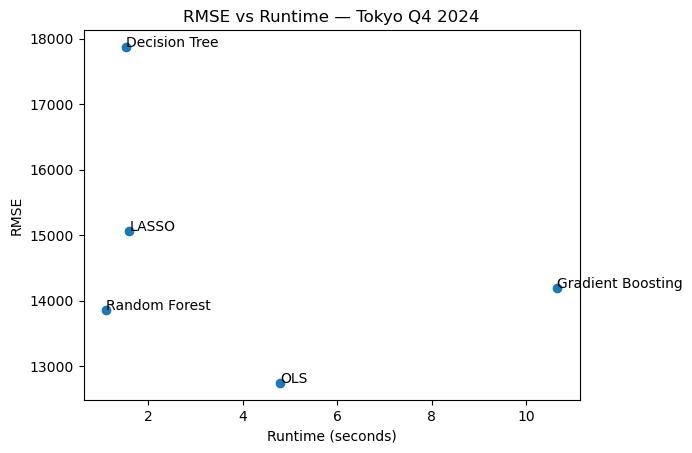

In [52]:
# Ensure Plots directory exists
os.makedirs("Plots", exist_ok=True)

models = [
    "OLS",
    "LASSO",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree"
]

rmse_tokyo_q4_2024 = [
    rmse_ols,
    rmse_lasso,
    rmse_rf,
    rmse_gb,
    rmse_dt
]

runtime_tokyo_q4_2024 = [
    runtime_ols,
    runtime_lasso,
    runtime_rf,
    runtime_gb,
    runtime_dt
]

plt.figure()
plt.scatter(runtime_tokyo_q4_2024, rmse_tokyo_q4_2024)

for i, model in enumerate(models):
    plt.text(runtime_tokyo_q4_2024[i], rmse_tokyo_q4_2024[i], model)

plt.xlabel("Runtime (seconds)")
plt.ylabel("RMSE")
plt.title("RMSE vs Runtime — Tokyo Q4 2024")

# Save plot (overwrite if exists)
plt.savefig("Plots/rmse-vs-runtime_tokyo_q4_2024.png", bbox_inches="tight")

plt.show()

##### B. Tokyo Listings in Q3 2025

RMSE vs Runtime Plot for Different Models

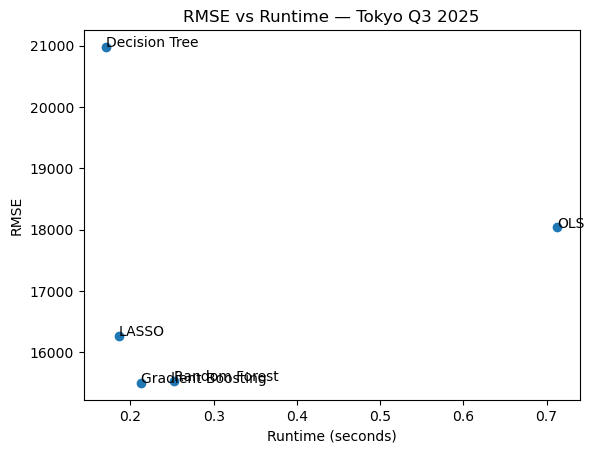

In [53]:
# Ensure Plots directory exists
os.makedirs("Plots", exist_ok=True)

models = [
    "OLS",
    "LASSO",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree"
]

rmse_tokyo_q3_2025 = [
    rmse_ols_val_tokyo_q3_2025,
    rmse_lasso_val_tokyo_q3_2025,
    rmse_rf_val_tokyo_q3_2025,
    rmse_gb_val_tokyo_q3_2025,
    rmse_dt_val_tokyo_q3_2025
]

runtime_tokyo_q3_2025 = [
    runtime_ols_val_tokyo_q3_2025,
    runtime_lasso_val_tokyo_q3_2025,
    runtime_rf_val_tokyo_q3_2025,
    runtime_gb_val_tokyo_q3_2025,
    runtime_dt_val_tokyo_q3_2025
]

plt.figure()
plt.scatter(runtime_tokyo_q3_2025, rmse_tokyo_q3_2025)

for i, model in enumerate(models):
    plt.text(runtime_tokyo_q3_2025[i], rmse_tokyo_q3_2025[i], model)

plt.xlabel("Runtime (seconds)")
plt.ylabel("RMSE")
plt.title("RMSE vs Runtime — Tokyo Q3 2025")

plt.savefig("Plots/rmse-vs-runtime_tokyo_q3_2025.png", bbox_inches="tight")

plt.show()


##### C. Hong Kong Listings for Latest Time Period

RMSE vs Runtime Plot for Different Models

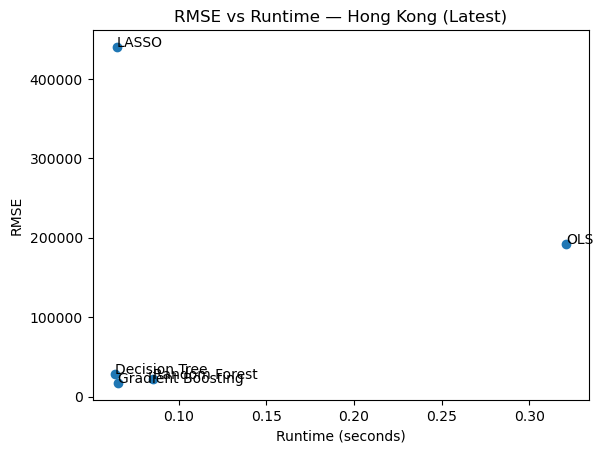

In [54]:
# Ensure Plots directory exists
os.makedirs("Plots", exist_ok=True)

models = [
    "OLS",
    "LASSO",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree"
]

rmse_hk = [
    rmse_ols_val_hk,
    rmse_lasso_val_hk,
    rmse_rf_val_hk,
    rmse_gb_val_hk,
    rmse_dt_val_hk
]

runtime_hk = [
    runtime_ols_val_hk,
    runtime_lasso_val_hk,
    runtime_rf_val_hk,
    runtime_gb_val_hk,
    runtime_dt_val_hk
]

plt.figure()
plt.scatter(runtime_hk, rmse_hk)

for i, model in enumerate(models):
    plt.text(runtime_hk[i], rmse_hk[i], model)

plt.xlabel("Runtime (seconds)")
plt.ylabel("RMSE")
plt.title("RMSE vs Runtime — Hong Kong (Latest)")

plt.savefig("Plots/rmse-vs-runtime_hk_latest.png", bbox_inches="tight")

plt.show()
